# Task A: Implementing the EM Algorithm for Soft Clustering

## Objective
The goal is to implement the EM algorithm for clustering data into 4 groups using Gaussian models. The method will first use K-means to initialize the cluster centers, and then iterate to optimize cluster assignments and parameters. The log-likelihood of the model will be calculated at each step, and its progression will be visualized.

---

## Steps for the EM Algorithm

### 1. Initialization
- Use K-means to find the initial cluster centers, calculate the spread of data points within each cluster (covariance), and estimate the initial probability of data belonging to each cluster.

### 2. Expectation Step (E-step)
- For each data point, calculate how likely it is to belong to each cluster. This likelihood is based on how close the data point is to the cluster center and how the data is distributed within the cluster.

### 3. Maximization Step (M-step)
- Use the likelihoods from the previous step to update the cluster centers, spreads, and probabilities to better fit the data.

### 4. Convergence
- Calculate the overall likelihood of the data being explained by the current clusters. Stop the algorithm if this likelihood improves only slightly between iterations or after a set number of iterations.

---

## Challenges
1. **Underflow**: When likelihood values become extremely small, numerical issues can occur. To avoid this, calculate log-likelihoods in a way that avoids tiny numbers.
2. **Covariance Issues**: If the spread of data within a cluster becomes too small, it can cause problems in calculations. Add a small constant to the spread values to ensure stability.

---

## K-Means as a Special Case
The EM algorithm reduces to K-means when the clusters have no spread and all data points are assigned completely to their nearest cluster center. In this case, there are no partial assignments or probabilities involved.

---

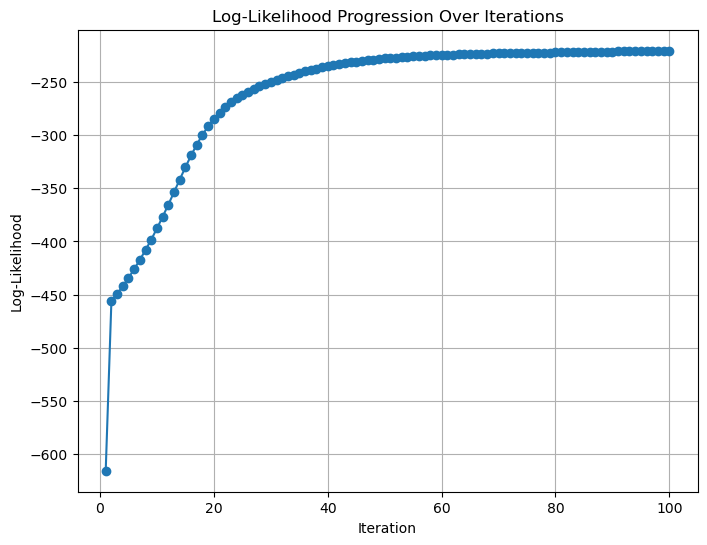

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate synthetic data
np.random.seed(42)
points_per_cluster = 100
centers = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
std_dev = 0.5
Xs = np.vstack([np.random.randn(points_per_cluster, 2) * std_dev + center for center in centers])

# Step 2: K-Means Initialization
def kmeans_init(Xs, k, max_iterations=100, tol=1e-4):
    n, d = Xs.shape
    prototypes = Xs[np.random.choice(n, k, replace=False)]  # Randomly initialize cluster centers
    for _ in range(max_iterations):
        distances = np.linalg.norm(Xs[:, None] - prototypes, axis=2)  # Compute distances
        assignments = np.argmin(distances, axis=1)  # Assign points to nearest cluster
        new_prototypes = np.array([
            Xs[assignments == i].mean(axis=0) if np.any(assignments == i) else prototypes[i]
            for i in range(k)
        ])
        if np.allclose(prototypes, new_prototypes, atol=tol):  # Check convergence
            break
        prototypes = new_prototypes
    return prototypes

# Initialize K-means
k = 4
means = kmeans_init(Xs, k)

# Step 3: EM Algorithm with Log-Sum-Exp Trick
def em_algorithm(Xs, k, means, max_iterations=100, tol=1e-6):
    n, d = Xs.shape
    covariances = [np.eye(d) for _ in range(k)]  # Initial covariances
    priors = np.full(k, 1 / k)  # Equal priors
    log_likelihoods = []

    for iteration in range(max_iterations):
        # E-step: Compute responsibilities (h_ij) with log-sum-exp trick
        assprob = np.zeros((n, k))
        for j in range(k):
            diff = Xs - means[j]
            e_j = -0.5 * np.sum(diff @ np.linalg.inv(covariances[j]) * diff, axis=1) - 0.5 * np.log(
                np.linalg.det(covariances[j])
            )
            assprob[:, j] = np.log(priors[j]) + e_j

        # Log-sum-exp trick
        max_e = np.max(assprob, axis=1, keepdims=True)  # Max value for stability
        assprob = np.exp(assprob - max_e)  # Subtract max_e
        assprob /= assprob.sum(axis=1, keepdims=True)  # Normalize

        # Compute log-likelihood
        log_likelihood = np.sum(np.log(np.sum(assprob, axis=1)) + max_e.flatten())
        log_likelihoods.append(log_likelihood)

        # M-step: Update priors, means, and covariances
        Nk = assprob.sum(axis=0)
        priors = Nk / n
        means = (assprob.T @ Xs) / Nk[:, None]
        covariances = []
        for j in range(k):
            diff = Xs - means[j]
            cov = (assprob[:, j, None] * diff).T @ diff / Nk[j]
            covariances.append(cov + 1e-6 * np.eye(d))  # Regularization

        # Check convergence
        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            print(f"EM converged after {iteration + 1} iterations.")
            break

    return means, covariances, priors, log_likelihoods

# Run EM algorithm
means, covariances, priors, log_likelihoods = em_algorithm(Xs, k, means)

# Step 4: Plot Log-Likelihood Progression
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(log_likelihoods) + 1), log_likelihoods, marker='o')
plt.title("Log-Likelihood Progression Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.grid()
plt.show()

Running EM for K = 2...
EM converged for K = 2 after 52 iterations.
Running EM for K = 3...
EM converged for K = 3 after 29 iterations.
Running EM for K = 4...
EM converged for K = 4 after 29 iterations.
Running EM for K = 5...
EM converged for K = 5 after 34 iterations.
Running EM for K = 6...
EM converged for K = 6 after 44 iterations.
Running EM for K = 7...
EM converged for K = 7 after 43 iterations.
Running EM for K = 8...
EM converged for K = 8 after 71 iterations.
Running EM for K = 9...
EM converged for K = 9 after 43 iterations.
Running EM for K = 10...
EM converged for K = 10 after 26 iterations.


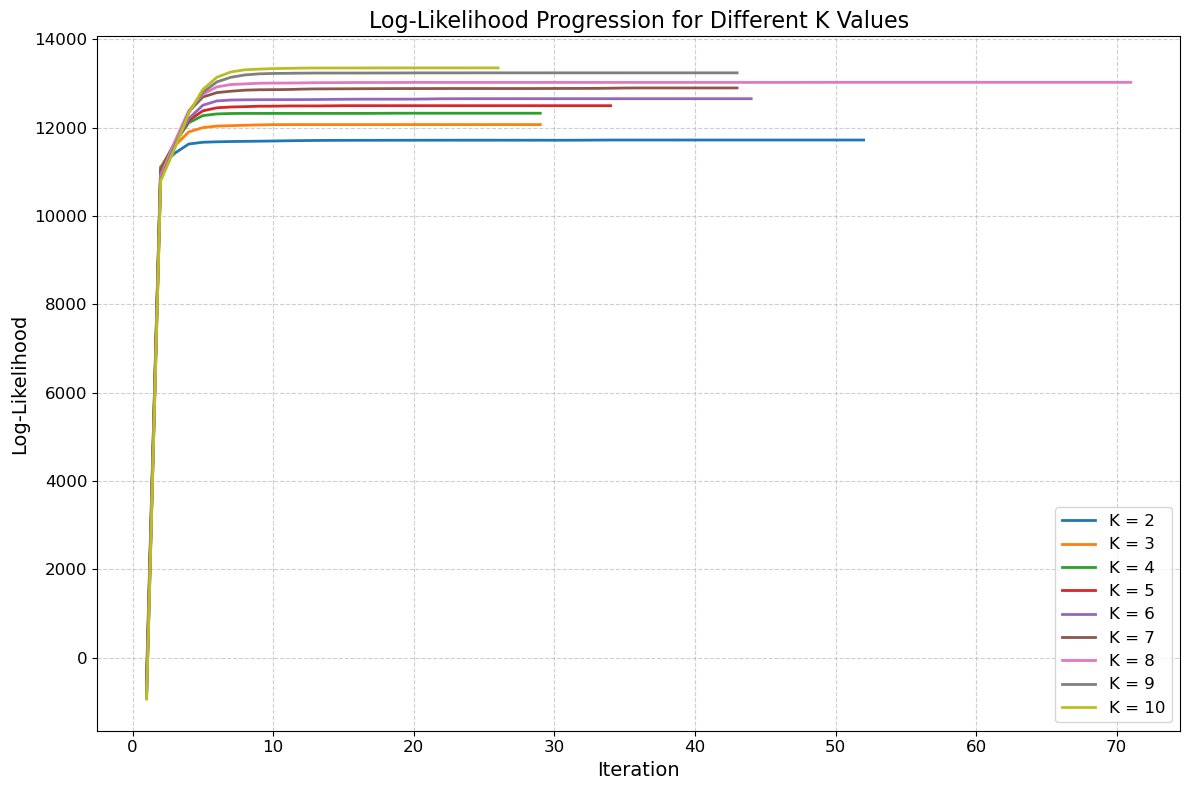

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load gene expression data
data_path = "GexprData.csv"  # Replace with your actual file path
gene_data = pd.read_csv(data_path).values  # Convert to NumPy array
X = gene_data
n, d = X.shape

# K-Means Initialization
def kmeans_init(X, k, max_iterations=100, tol=1e-4):
    n, d = X.shape
    prototypes = X[np.random.choice(n, k, replace=False)]  # Randomly initialize cluster centers
    for _ in range(max_iterations):
        distances = np.linalg.norm(X[:, None] - prototypes, axis=2)  # Compute distances
        assignments = np.argmin(distances, axis=1)  # Assign points to nearest cluster
        new_prototypes = np.array([
            X[assignments == i].mean(axis=0) if np.any(assignments == i) else prototypes[i]
            for i in range(k)
        ])
        if np.allclose(prototypes, new_prototypes, atol=tol):  # Check convergence
            break
        prototypes = new_prototypes
    return prototypes

# EM Algorithm
def em_algorithm(X, k, means, max_iterations=100, tol=1e-4):
    covariances = [np.eye(d) for _ in range(k)]  # Initial covariances
    priors = np.full(k, 1 / k)  # Equal priors
    log_likelihoods = []

    for iteration in range(max_iterations):
        # E-step: Compute assignment probabilities (assprob) with log-sum-exp trick
        assprob = np.zeros((n, k))
        for j in range(k):
            diff = X - means[j]
            e_j = -0.5 * np.sum(diff @ np.linalg.inv(covariances[j]) * diff, axis=1) - 0.5 * np.log(
                np.linalg.det(covariances[j])
            )
            assprob[:, j] = np.log(priors[j]) + e_j

        # Log-sum-exp trick
        max_e = np.max(assprob, axis=1, keepdims=True)  # Max value for stability
        assprob = np.exp(assprob - max_e)  # Subtract max_e
        assprob /= assprob.sum(axis=1, keepdims=True)  # Normalize

        # Compute log-likelihood
        log_likelihood = np.sum(np.log(np.sum(assprob, axis=1)) + max_e.flatten())
        log_likelihoods.append(log_likelihood)

        # M-step: Update priors, means, and covariances
        Nk = assprob.sum(axis=0)
        priors = Nk / n
        means = (assprob.T @ X) / Nk[:, None]
        covariances = []
        for j in range(k):
            diff = X - means[j]
            cov = (assprob[:, j, None] * diff).T @ diff / Nk[j]
            covariances.append(cov + 1e-6 * np.eye(d))  # Regularization

        # Check convergence
        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            print(f"EM converged for K = {k} after {iteration + 1} iterations.")
            break

    return log_likelihoods

# Test EM algorithm for K = 2 to 10
K_values = range(2, 11)
log_likelihood_results = {}

for k in K_values:
    print(f"Running EM for K = {k}...")
    means = kmeans_init(X, k)  # Initialize means using K-means
    log_likelihoods = em_algorithm(X, k, means)
    log_likelihood_results[k] = log_likelihoods

import matplotlib.pyplot as plt

# Plot Log-Likelihood Progression for Different K
plt.figure(figsize=(12, 8))  # Larger figure size

# Plot only every 2nd iteration to reduce clutter
for k, log_likelihoods in log_likelihood_results.items():
    iterations = range(1, len(log_likelihoods) + 1)
    plt.plot(
        iterations, log_likelihoods,
        label=f"K = {k}",
        marker=None,  # Remove markers to reduce clutter
        linewidth=2  # Increase line width for clarity
    )

# Customize the plot
plt.title("Log-Likelihood Progression for Different K Values", fontsize=16)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Log-Likelihood", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, loc='lower right')  # Adjust legend location and size
plt.tight_layout()  # Adjust padding
plt.show()


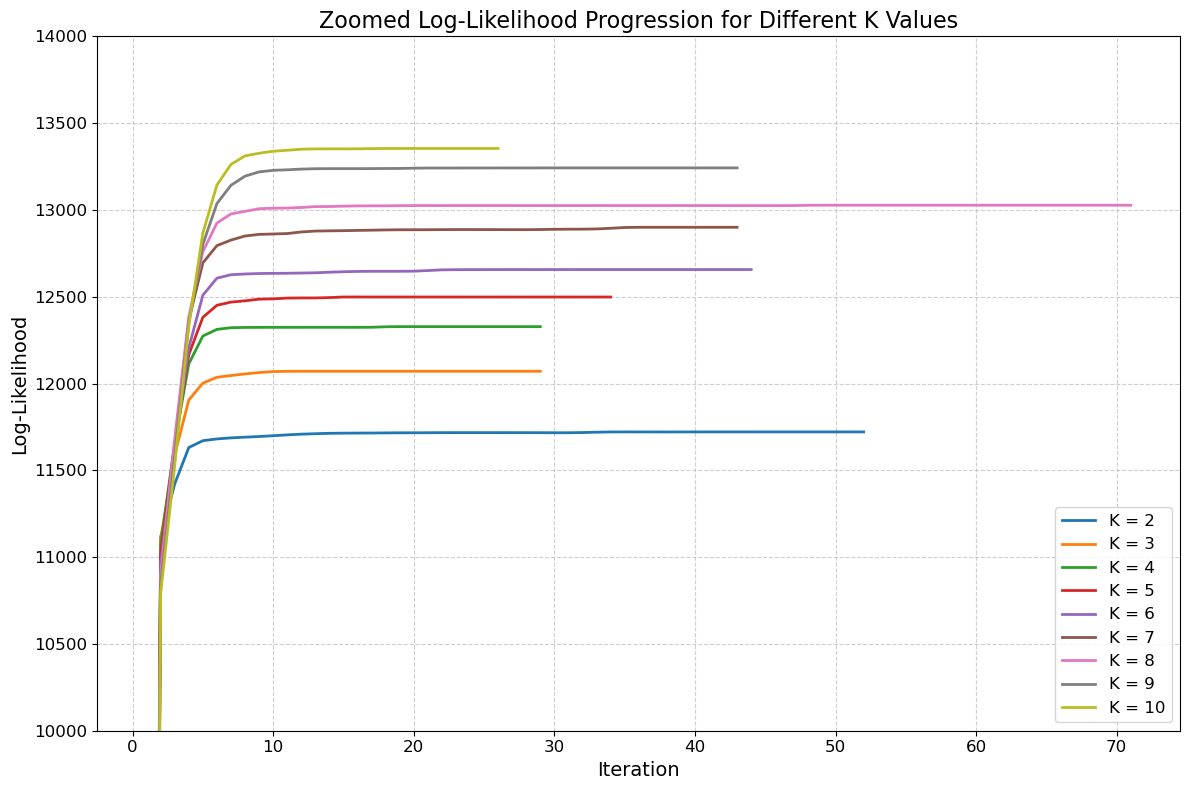

In [29]:
# Plot Log-Likelihood Progression for Different K (Zoomed-in)
plt.figure(figsize=(12, 8))  # Larger figure size

# Plot all K values
for k, log_likelihoods in log_likelihood_results.items():
    iterations = range(1, len(log_likelihoods) + 1)
    plt.plot(
        iterations, log_likelihoods,
        label=f"K = {k}",
        linewidth=2  # Increase line width for clarity
    )

# Zoom in on the range of log-likelihood values
plt.ylim(10000, 14000)  # Set y-axis limits

# Customize the plot
plt.title("Zoomed Log-Likelihood Progression for Different K Values", fontsize=16)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Log-Likelihood", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, loc='lower right')  # Adjust legend location and size
plt.tight_layout()  # Adjust padding
plt.show()

Running EM for K = 2...
EM converged for K = 2 after 57 iterations.
Running EM for K = 3...
EM converged for K = 3 after 29 iterations.
Running EM for K = 4...
EM converged for K = 4 after 25 iterations.
Running EM for K = 5...
EM converged for K = 5 after 46 iterations.
Running EM for K = 6...
EM converged for K = 6 after 42 iterations.
Running EM for K = 7...
EM converged for K = 7 after 87 iterations.
Running EM for K = 8...
EM converged for K = 8 after 43 iterations.
Running EM for K = 9...
EM converged for K = 9 after 42 iterations.
Running EM for K = 10...
EM converged for K = 10 after 49 iterations.


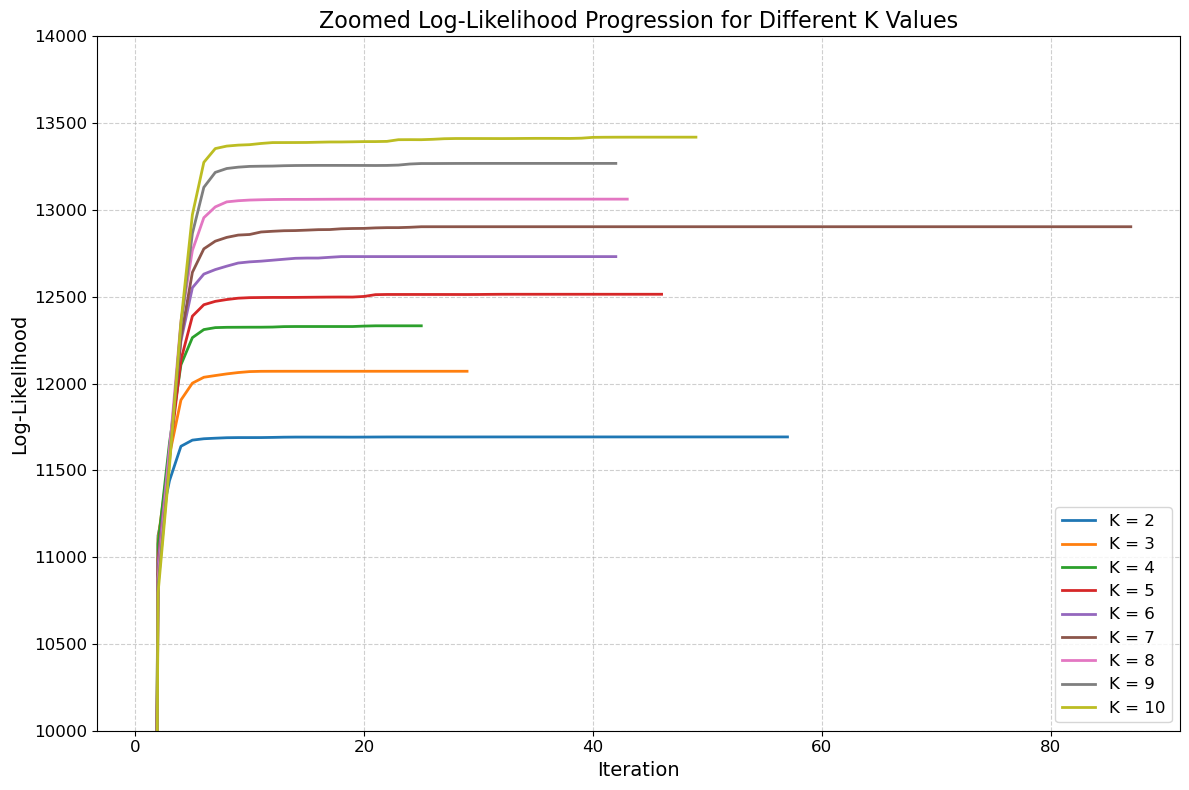

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the gene expression data from GexprData.csv
data_path = "GexprData.csv"  # Replace with the correct path if needed
gene_data = pd.read_csv(data_path).values  # Convert to NumPy array
X = gene_data
n, d = X.shape  # Number of samples and dimensions

# K-Means Initialization
def kmeans_init(X, k, max_iterations=100, tol=1e-4):
    n, d = X.shape
    prototypes = X[np.random.choice(n, k, replace=False)]  # Randomly initialize cluster centers
    for _ in range(max_iterations):
        distances = np.linalg.norm(X[:, None] - prototypes, axis=2)  # Compute distances
        assignments = np.argmin(distances, axis=1)  # Assign points to nearest cluster
        new_prototypes = np.array([
            X[assignments == i].mean(axis=0) if np.any(assignments == i) else prototypes[i]
            for i in range(k)
        ])
        if np.allclose(prototypes, new_prototypes, atol=tol):  # Check convergence
            break
        prototypes = new_prototypes
    return prototypes

# EM Algorithm
def em_algorithm(X, k, means, max_iterations=100, tol=1e-4):
    covariances = [np.eye(d) for _ in range(k)]  # Initial covariances
    priors = np.full(k, 1 / k)  # Equal priors
    log_likelihoods = []

    for iteration in range(max_iterations):
        # E-step: Compute assignment probabilities (assprob) with log-sum-exp trick
        assprob = np.zeros((n, k))
        for j in range(k):
            diff = X - means[j]
            e_j = -0.5 * np.sum(diff @ np.linalg.inv(covariances[j]) * diff, axis=1) - 0.5 * np.log(
                np.linalg.det(covariances[j])
            )
            assprob[:, j] = np.log(priors[j]) + e_j

        # Log-sum-exp trick
        max_e = np.max(assprob, axis=1, keepdims=True)  # Max value for stability
        assprob = np.exp(assprob - max_e)  # Subtract max_e
        assprob /= assprob.sum(axis=1, keepdims=True)  # Normalize

        # Compute log-likelihood
        log_likelihood = np.sum(np.log(np.sum(assprob, axis=1)) + max_e.flatten())
        log_likelihoods.append(log_likelihood)

        # M-step: Update priors, means, and covariances
        Nk = assprob.sum(axis=0)
        priors = Nk / n
        means = (assprob.T @ X) / Nk[:, None]
        covariances = []
        for j in range(k):
            diff = X - means[j]
            cov = (assprob[:, j, None] * diff).T @ diff / Nk[j]
            covariances.append(cov + 1e-6 * np.eye(d))  # Regularization

        # Check convergence
        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            print(f"EM converged for K = {k} after {iteration + 1} iterations.")
            break

    return log_likelihoods

# Test EM algorithm for K = 2 to 10
K_values = range(2, 11)
log_likelihood_results = {}

for k in K_values:
    print(f"Running EM for K = {k}...")
    means = kmeans_init(X, k)  # Initialize means using K-means
    log_likelihoods = em_algorithm(X, k, means)
    log_likelihood_results[k] = log_likelihoods

# Plot Log-Likelihood Progression for Different K (Zoomed-in)
plt.figure(figsize=(12, 8))  # Larger figure size

# Plot all K values
for k, log_likelihoods in log_likelihood_results.items():
    iterations = range(1, len(log_likelihoods) + 1)
    plt.plot(
        iterations, log_likelihoods,
        label=f"K = {k}",
        linewidth=2  # Increase line width for clarity
    )

# Zoom in on the range of log-likelihood values
plt.ylim(10000, 14000)  # Adjust range as necessary based on your data

# Customize the plot
plt.title("Zoomed Log-Likelihood Progression for Different K Values", fontsize=16)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Log-Likelihood", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, loc='lower right')  # Adjust legend location and size
plt.tight_layout()  # Adjust padding
plt.show()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the Word Count Data
data_path = "CountData.csv"  # Replace with your actual file path
count_data = pd.read_csv(data_path).values  # Convert to NumPy array
X = count_data
n, d = X.shape  # Number of samples and dimensions
print(X.shape)  # Should output (number of rows, number of columns)
print(np.isnan(X).sum())  # Should be 0, indicating no NaN values

(1352, 136)
0


Data loaded successfully. Shape: (1352, 136)
Initializing K-Means for EM...
Initialized K-Means with 10 clusters.
K-Means converged after 9 iterations.
Running EM algorithm...
Starting EM iteration 1...
Log-likelihood after iteration 1: -3113.248234285956
Starting EM iteration 2...
Log-likelihood after iteration 2: 11695.133316509007
Starting EM iteration 3...
Log-likelihood after iteration 3: 11694.727091407527
Starting EM iteration 4...
Log-likelihood after iteration 4: 11694.49085590275
Starting EM iteration 5...
Log-likelihood after iteration 5: 11694.38980821232
Starting EM iteration 6...
Log-likelihood after iteration 6: 11694.376436793802
Starting EM iteration 7...
Log-likelihood after iteration 7: 11694.371317965422
Starting EM iteration 8...
Log-likelihood after iteration 8: 11694.367974139881
Starting EM iteration 9...
Log-likelihood after iteration 9: 11694.36603963629
Starting EM iteration 10...
Log-likelihood after iteration 10: 11694.364969137188
Starting EM iteration 11.

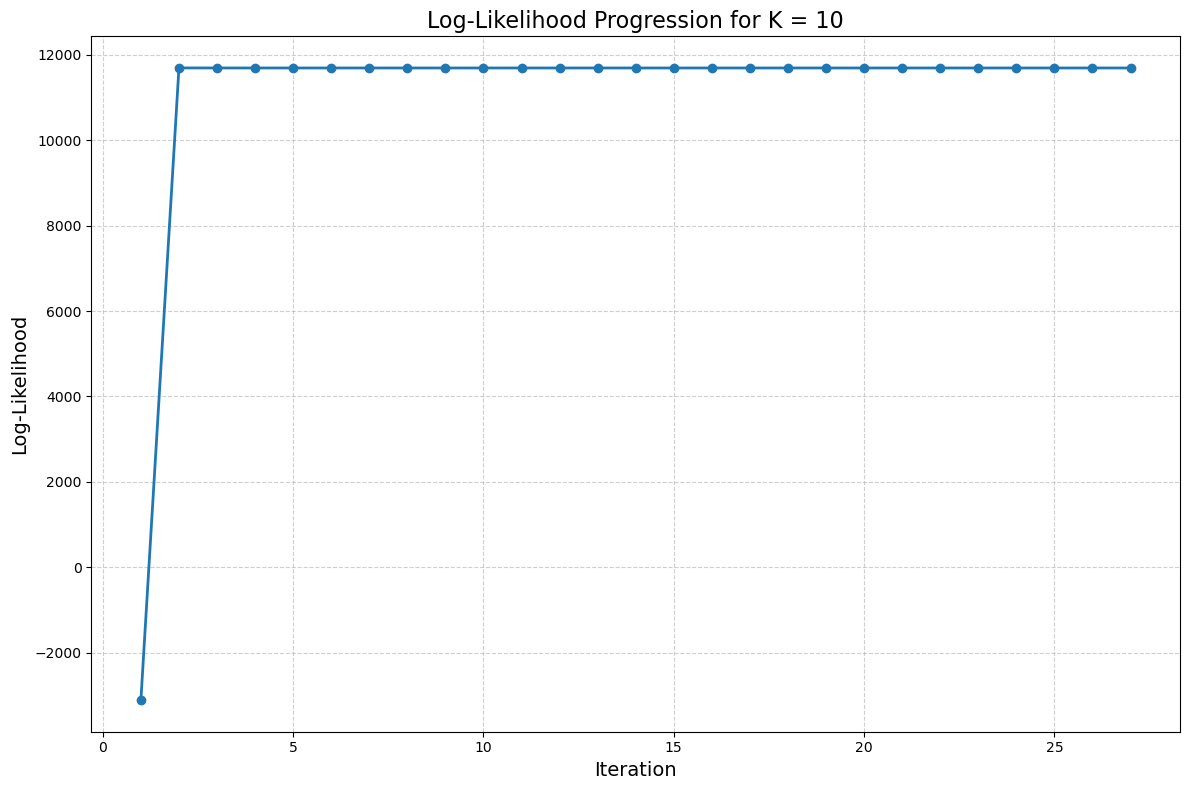

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the Word Count Data
data_path = "CountData.csv"  # Replace with your actual file path
count_data = pd.read_csv(data_path).values  # Convert to NumPy array
X = np.nan_to_num(count_data)  # Replace NaN values with 0
n, d = X.shape  # Number of samples and dimensions

print(f"Data loaded successfully. Shape: {X.shape}")

# Efficient Distance Calculation with NumPy
def compute_distances(X, prototypes):
    """Efficient distance calculation using matrix operations."""
    distances_squared = (
        np.sum(X**2, axis=1)[:, None]
        + np.sum(prototypes**2, axis=1)
        - 2 * X @ prototypes.T
    )
    return np.sqrt(np.clip(distances_squared, 0, None))  # Clamp to avoid negatives

# K-Means Initialization
def kmeans_init(X, k, max_iterations=100, tol=1e-4):
    n, d = X.shape
    prototypes = X[np.random.choice(n, k, replace=False)]  # Randomly initialize cluster centers
    print(f"Initialized K-Means with {k} clusters.")
    for iteration in range(max_iterations):
        distances = compute_distances(X, prototypes)  # Efficient distance calculation
        assignments = np.argmin(distances, axis=1)  # Assign points to nearest cluster
        new_prototypes = np.array([
            X[assignments == i].mean(axis=0) if np.any(assignments == i) else prototypes[i]
            for i in range(k)
        ])
        if np.allclose(prototypes, new_prototypes, atol=tol):  # Check convergence
            print(f"K-Means converged after {iteration + 1} iterations.")
            break
        prototypes = new_prototypes
    return prototypes

# EM Algorithm
def em_algorithm(X, k, means, max_iterations=100, tol=1e-4):
    covariances = [np.eye(d) for _ in range(k)]  # Initial covariances
    priors = np.full(k, 1 / k)  # Equal priors
    log_likelihoods = []

    for iteration in range(max_iterations):
        print(f"Starting EM iteration {iteration + 1}...")
        # E-step: Compute assignment probabilities (assprob) with log-sum-exp trick
        assprob = np.zeros((n, k))
        for j in range(k):
            diff = X - means[j]
            try:
                e_j = -0.5 * np.sum(diff @ np.linalg.inv(covariances[j]) * diff, axis=1)
                e_j -= 0.5 * np.log(max(np.linalg.det(covariances[j]), 1e-10))  # Regularize determinant
            except np.linalg.LinAlgError:
                print(f"Covariance matrix for cluster {j} is singular. Adding regularization.")
                covariances[j] += 1e-3 * np.eye(d)  # Regularize covariance
                e_j = -0.5 * np.sum(diff @ np.linalg.inv(covariances[j]) * diff, axis=1)
            assprob[:, j] = np.log(priors[j]) + e_j

        # Log-sum-exp trick
        max_e = np.nan_to_num(np.max(assprob, axis=1, keepdims=True), nan=-np.inf)  # Handle NaN or infinity
        assprob = np.exp(assprob - max_e)  # Subtract max_e
        assprob = np.clip(assprob, 1e-10, 1.0)  # Clip to valid probabilities
        assprob /= assprob.sum(axis=1, keepdims=True)  # Normalize

        # Compute log-likelihood
        log_likelihood = np.sum(np.log(np.sum(assprob, axis=1)) + max_e.flatten())
        log_likelihoods.append(log_likelihood)
        print(f"Log-likelihood after iteration {iteration + 1}: {log_likelihood}")

        # M-step: Update priors, means, and covariances
        Nk = assprob.sum(axis=0)
        priors = Nk / n
        means = (assprob.T @ X) / Nk[:, None]
        covariances = []
        for j in range(k):
            diff = X - means[j]
            if Nk[j] < 1e-6:  # Handle empty clusters
                print(f"Cluster {j} is empty. Reinitializing.")
                means[j] = X[np.random.choice(len(X))]
                covariances.append(np.eye(d))
                priors[j] = 1 / k
            else:
                cov = (assprob[:, j, None] * diff).T @ diff / Nk[j]
                covariances.append(cov + 1e-3 * np.eye(d))  # Increase regularization

        # Check convergence
        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            print(f"EM converged for K = {k} after {iteration + 1} iterations.")
            break

    return log_likelihoods

# Test EM algorithm with K = 10
k = 10
print("Initializing K-Means for EM...")
means = kmeans_init(X, k)  # Initialize means using K-means
print("Running EM algorithm...")
log_likelihoods = em_algorithm(X, k, means)

# Plot Log-Likelihood Progression for K = 10
plt.figure(figsize=(12, 8))
iterations = range(1, len(log_likelihoods) + 1)
plt.plot(iterations, log_likelihoods, marker='o', linewidth=2)
plt.title("Log-Likelihood Progression for K = 10", fontsize=16)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Log-Likelihood", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

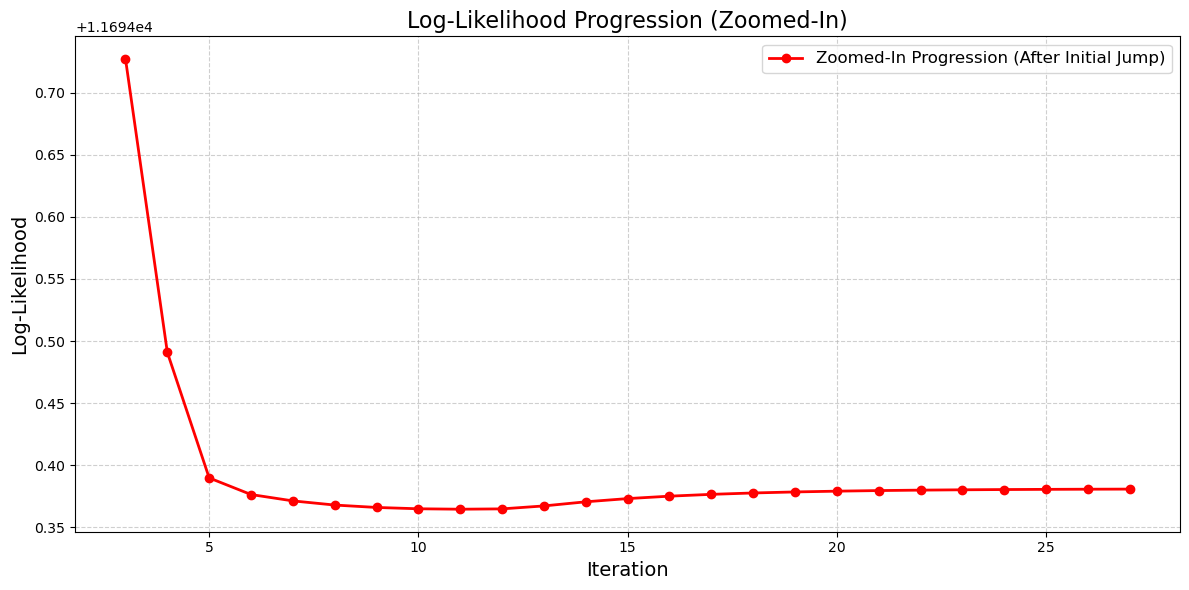

In [10]:
# Plot the later iterations (zoomed-in)
plt.figure(figsize=(12, 6))
zoom_start = 2  # Focus on iterations after the large jump
plt.plot(
    iterations[zoom_start:],
    log_likelihoods[zoom_start:],
    marker='o',
    color='red',
    linewidth=2,
    label="Zoomed-In Progression (After Initial Jump)",
)
plt.title("Log-Likelihood Progression (Zoomed-In)", fontsize=16)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Log-Likelihood", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### **Answers to Additional Questions**

#### **1. What kind of processing has possibly been applied to obtain these numerical values?**
The numerical values in the `CountData.csv` file likely represent normalized tetramer frequencies. This normalization could involve dividing the raw counts of tetramers by the total count of all tetramers in a sequence, resulting in relative frequencies. Additionally, transformations such as log-transformation or z-score standardization might have been applied to handle the wide range of tetramer counts and reduce the influence of outliers.

#### **2. Why are there 136 dimensions to represent tetramer-frequencies instead of 256?**
There are 136 dimensions instead of 256 because only biologically meaningful tetramers are represented. Many combinations of 4-length sequences are not biologically valid due to the constraints of DNA sequences, such as overlapping palindromes, GC content bias, or complementary strand symmetry. Additionally, symmetry properties of DNA sequences could have been used to reduce redundancy, grouping complementary sequences into the same dimension.

#### **3. How can you use NumPy matrix multiplication (`@` operator) to efficiently calculate distances?**
Efficient distance calculations can be achieved using NumPy matrix multiplication (`@`) instead of explicit loops.
In code:
```python
distances_squared = (
    np.sum(X**2, axis=1)[:, None]  # Row-wise sum of X^2
    + np.sum(P**2, axis=1)         # Column-wise sum of P^2
    - 2 * (X @ P.T)                # Matrix multiplication
)

### **Task 2: Bayes Information Criterion (BIC)**

#### **1. Calculating the Bayes Information Criterion**
The BIC is calculated using the formula:
\[
BIC = 2 \cdot \log(L(\theta)) - M \cdot \log(N)
\]
Where:
- \( L(\theta) \): Log-likelihood of the estimated model.
- \( M \): Number of free parameters in the model.
- \( N \): Number of data points.

**Steps**:
1. For each value of \( K \) (number of prototypes), compute the log-likelihood \( L(\theta) \) from the EM algorithm.
2. Calculate \( M \), the number of free parameters, as:
   \[
   M = k \cdot d + k \cdot \frac{d \cdot (d + 1)}{2} + k - 1
   \]
   - \( k \): Number of prototypes.
   - \( d \): Number of dimensions in the data.
   - \( k \cdot d \): Parameters for the means.
   - \( k \cdot \frac{d \cdot (d + 1)}{2} \): Parameters for the covariance matrices.
   - \( k - 1 \): Parameters for the priors (sum of priors must equal 1).
3. Compute the BIC score for each \( K \) and visualize it in a plot.

#### **2. Compare BIC Scores for Datasets**
- For the synthetic data and gene expression data (GexprData.csv), compute the BIC scores for \( K = 2, \ldots, 10 \).
- For the "Word Count" data (CountData.csv), compute the BIC scores for \( K = 2, \ldots, 15 \).

#### **3. Visualizing the Elbow Criterion**
For \( K \) values from \( 2 \) to \( 15 \), visualize the elbow criterion using the average quadratic error (AQE) from the K-means initialization. This is analogous to Sheet 3, Task 2.

#### **4. Identifying a Meaningful Number of Clusters**
The BIC may not always indicate the actual number of clusters/genomes in metagenomic data due to:
- Variability in genome composition.
- Uneven bin sizes.

**Additional Information to Identify Clusters/Bins**:
- **Phylogenetic markers**: Use conserved genes to verify the number of clusters.
- **Coverage profiles**: Cluster contigs based on abundance across samples.
- **Functional annotations**: Use predicted gene functions to refine bins.
- **Co-assembly comparisons**: Evaluate clustering results against co-assembly data.

Applying PCA to Word Count Data...
Word Count Data reduced to shape: (1352, 50)
Synthetic Data | K=2, BIC=-422.0700247881295, Log-Likelihood=-178.08195738497085
Synthetic Data | K=3, BIC=-496.7070510173054, Log-Likelihood=-197.42607685823486
Synthetic Data | K=4, BIC=-640.6615862098181, Log-Likelihood=-251.4289508131673
Synthetic Data | K=5, BIC=-820.5296935700854, Log-Likelihood=-323.388610851977
Synthetic Data | K=6, BIC=-956.1240332931934, Log-Likelihood=-373.211387072207
Synthetic Data | K=7, BIC=-1108.7629361135068, Log-Likelihood=-431.55644484103976
Synthetic Data | K=8, BIC=-1178.266983605718, Log-Likelihood=-448.3340749458214
Synthetic Data | K=9, BIC=-1257.3919303576808, Log-Likelihood=-469.92215468047885
Synthetic Data | K=10, BIC=-1318.4900618479364, Log-Likelihood=-482.4968267842828
EM converged for K=2 after 11 iterations.
Gene Expression Data | K=2, BIC=-2814.857113686825, Log-Likelihood=-393.2885911881124
Gene Expression Data | K=3, BIC=-4238.462598262075, Log-Likelihood

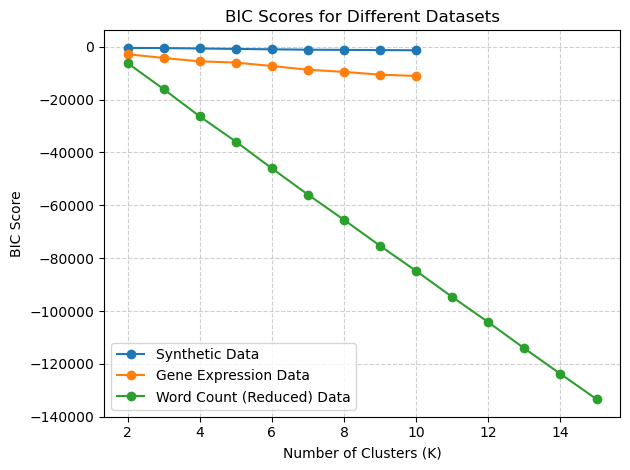

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Generate Synthetic Data
np.random.seed(42)
points_per_cluster = 100
centers = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
std_dev = 0.5
X_synthetic = np.vstack([np.random.randn(points_per_cluster, 2) * std_dev + center for center in centers])

# Load Datasets
X_gexpr = pd.read_csv("GexprData.csv").values  # Gene Expression Data
X_word_count = pd.read_csv("CountData.csv").values  # Word Count Data

# PCA for Word Count Data
print("Applying PCA to Word Count Data...")
pca = PCA(n_components=50)  # Reduce dimensionality to 50
X_word_count_reduced = pca.fit_transform(X_word_count)
print(f"Word Count Data reduced to shape: {X_word_count_reduced.shape}")

# K-Means Initialization
def kmeans_init(X, k, max_iterations=100, tol=1e-4):
    n, d = X.shape
    prototypes = X[np.random.choice(n, k, replace=False)]  # Randomly initialize cluster centers
    for _ in range(max_iterations):
        distances = np.linalg.norm(X[:, None] - prototypes, axis=2)  # Compute distances
        assignments = np.argmin(distances, axis=1)  # Assign points to nearest cluster
        new_prototypes = np.array([
            X[assignments == i].mean(axis=0) if np.any(assignments == i) else prototypes[i]
            for i in range(k)
        ])
        if np.allclose(prototypes, new_prototypes, atol=tol):  # Check convergence
            break
        prototypes = new_prototypes
    return prototypes

# Optimized EM Algorithm
def em_algorithm(X, k, means, max_iterations=30, tol=1e-4):  # Adjust max_iterations
    n, d = X.shape
    covariances = [np.eye(d) for _ in range(k)]  # Initial covariances
    priors = np.full(k, 1 / k)  # Equal priors
    log_likelihoods = []

    for iteration in range(max_iterations):
        # E-step
        assprob = np.zeros((n, k))
        for j in range(k):
            diff = X - means[j]
            try:
                cov_inv = np.linalg.inv(covariances[j])
                log_det = np.log(np.linalg.det(covariances[j]) + 1e-6)  # Regularize determinant
                e_j = -0.5 * np.sum(diff @ cov_inv * diff, axis=1) - 0.5 * log_det
                assprob[:, j] = np.log(priors[j]) + e_j
            except np.linalg.LinAlgError:
                print(f"Cluster {j}: Singular covariance. Adding regularization.")
                covariances[j] += 1e-4 * np.eye(d)

        max_e = np.nan_to_num(np.max(assprob, axis=1, keepdims=True), nan=-np.inf)
        assprob = np.clip(np.exp(assprob - max_e), 1e-10, 1.0)
        assprob /= assprob.sum(axis=1, keepdims=True)

        # Log-likelihood
        log_likelihood = np.sum(np.log(np.sum(assprob, axis=1)) + max_e.flatten())
        log_likelihoods.append(log_likelihood)

        # Early Stopping
        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            print(f"EM converged for K={k} after {iteration + 1} iterations.")
            break

        # M-step
        Nk = assprob.sum(axis=0)
        priors = Nk / n
        means = (assprob.T @ X) / Nk[:, None]
        covariances = []
        for j in range(k):
            diff = X - means[j]
            if Nk[j] < 1e-6:  # Handle empty clusters
                print(f"Cluster {j}: Reinitializing poorly defined cluster.")
                means[j] = X[np.random.choice(len(X))]
                covariances.append(np.eye(d))
            else:
                cov = (assprob[:, j, None] * diff).T @ diff / Nk[j]
                covariances.append(cov + 1e-4 * np.eye(d))  # Regularization

    return means, covariances, priors, log_likelihoods

# BIC Calculation
def calculate_bic(log_likelihood, k, n, d):
    m = k * d + k * (d * (d + 1)) / 2 + k - 1
    return 2 * log_likelihood - m * np.log(n)

# Process Each Dataset
datasets = {
    "Synthetic": X_synthetic,
    "Gene Expression": X_gexpr,
    "Word Count (Reduced)": X_word_count_reduced,
}
bic_scores = {}

for name, data in datasets.items():
    n, d = data.shape
    bic = []
    for k in range(2, 16 if name == "Word Count (Reduced)" else 11):
        means = kmeans_init(data, k)
        _, _, _, log_likelihoods = em_algorithm(data, k, means)
        bic_score = calculate_bic(log_likelihoods[-1], k, n, d)
        bic.append(bic_score)
        print(f"{name} Data | K={k}, BIC={bic_score}, Log-Likelihood={log_likelihoods[-1]}")
    bic_scores[name] = bic
    plt.plot(range(2, 16 if name == "Word Count (Reduced)" else 11), bic, marker='o', label=f"{name} Data")

# Plot BIC Scores
plt.title("BIC Scores for Different Datasets")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("BIC Score")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Binning of metagenomic contigs is an important application for clustering. However, the Bayes Information Criterion (BIC) may not always indicate the actual number of genomes in the data due to the complexity of the dataset and the statistical nature of BIC. To identify a meaningful number of clusters/bins, the following additional information can be used:

1. **Coverage and Abundance Data**:
   - Analyze the co-abundance patterns of contigs across multiple samples.
   - Contigs belonging to the same genome often exhibit correlated coverage patterns.

2. **Sequence Composition Features**:
   - Use features like GC content, k-mer frequencies, and codon usage bias.
   - These are often specific to individual genomes and help refine clusters.

3. **Phylogenetic Information**:
   - Align contigs to reference genomes or marker genes.
   - Phylogenetic proximity can guide the clustering process.

4. **Completeness and Contamination Metrics**:
   - Tools like CheckM can assess bins for completeness (presence of expected marker genes) and contamination (presence of unexpected genes).
   - Ensure that bins represent near-complete genomes.

5. **Taxonomic Assignments**:
   - Use tools like Kraken or Centrifuge to assign contigs to taxonomic groups.
   - Validate and refine clusters based on consistent taxonomic classifications.

6. **Functional Annotations**:
   - Group contigs based on predicted gene functions or metabolic pathways.
   - Bins with coherent functional annotations are more likely to represent meaningful genomes.

7. **Co-Occurrence Analysis**:
   - Examine co-occurrence patterns across samples.
   - Contigs that consistently co-occur likely belong to the same genome.

8. **Alternative Clustering Metrics**:
   - Use metrics like the **Silhouette Score** or **Gap Statistic** to evaluate cluster quality.
   - These metrics assess separation and cohesion of clusters, complementing the BIC score.

9. **External Reference Genomes**:
   - Align contigs to databases of known genomes.
   - Validate clusters against reference data to ensure biological relevance.

10. **Manual Inspection and Domain Expertise**:
    - Engage experts to manually inspect and validate clusters.
    - Ensure that clusters align with known genomic or biological characteristics.

### **Conclusion**
While BIC provides a statistical measure of model fit, combining it with additional biological and functional data ensures robust and biologically meaningful clusters. A multi-faceted approach is crucial for effective metagenomic binning.

---

### **References**

1. Parks, D. H., Imelfort, M., Skennerton, C. T., Hugenholtz, P., & Tyson, G. W. (2015). CheckM: assessing the quality of microbial genomes recovered from isolates, single cells, and metagenomes. *Genome Research*, 25(7), 1043–1055. https://doi.org/10.1101/gr.186072.114

2. Wood, D. E., Lu, J., & Langmead, B. (2019). Improved metagenomic analysis with Kraken 2. *Genome Biology*, 20, Article 257. https://doi.org/10.1186/s13059-019-1891-0

3. Ondov, B. D., Bergman, N. H., & Phillippy, A. M. (2011). Interactive metagenomic visualization in a Web browser. *BMC Bioinformatics*, 12, Article 385. https://doi.org/10.1186/1471-2105-12-385

4. Meyer, F., Paarmann, D., D'Souza, M., et al. (2008). The metagenomics RAST server – a public resource for the automatic phylogenetic and functional analysis of metagenomes. *BMC Bioinformatics*, 9, Article 386. https://doi.org/10.1186/1471-2105-9-386
